In [9]:
import sys
import os
current_dir = os.path.abspath('')  # 获取当前目录的绝对路径
parent_dir = os.path.dirname(current_dir)  # 获取父目录
sys.path.append(parent_dir)  # 添加父目录到 Python 路径
sys.path.append(parent_dir + '\\scripts')

from auto_plot import *

print("Current directory:", current_dir)
print("Parent directory:", parent_dir)

%load_ext autoreload
%aimport source, vis, pinn, dde_param
%autoreload 1
%aimport

import source, auto_plot, vis, pinn

Current directory: d:\Git\PINN-LiDAR\sample
Parent directory: d:\Git\PINN-LiDAR
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
dde_param pinn source vis

Modules to skip:



In [10]:
from source import create_source
from vis import Avis
import numpy as np

# Define basic parameters
params = {
    'c': 343,      # Speed of sound in m/s
    'amp': 1.0,
    'loc': [0, 0, 0],  # Source at origin
    't': 0,         # Time in 
    'freq': 5000
}

# Create source instances using factory function
spherical = create_source('spherical', **params)

# # Update specific parameters for each source type
spherical.update_params(radius=0.5)

C:\Users\1ieng\AppData\Local\Temp\ipykernel_24420\950354496.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


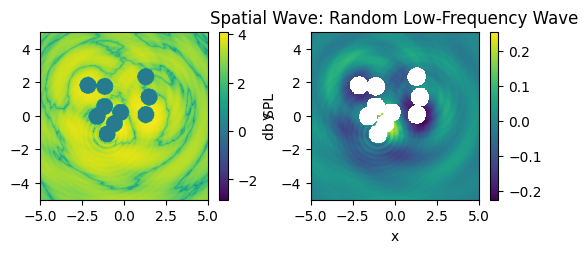

In [ ]:

import matplotlib.pyplot as plt
from matplotlib import cm

# Domain and grid setup
L = 10.0
N = 256
spherical.freq = 400

grid_params = {
    'grid_size': N,
    'x_range': (-L/2, L/2),
    'y_range': (-L/2, L/2)
}

spherical.update_params(radius = 0.5, max_order = 10)

pressure = np.zeros_like(Avis.create_heat_map(spherical, grid_params, t = 2))

# Create a random wave with low-frequency components

np.random.seed(21)  # For reproducibility
rand_freq_upper = 4000  # Limiting to low frequency
r_upper = 0.1 # limit the radius upper

rand_num = 10

freq = (np.random.rand(rand_num)) * rand_freq_upper
# random choose the loc
loc = [(np.random.rand(3) - 0.5) * L/2 for _ in range(rand_num)]

radius = (np.random.rand(rand_num)) * r_upper

source_data = {"freq": freq, "loc": loc, "radius": radius}

for f, l in zip(freq, loc):
    spherical.update_params(freq = f, loc = l)
    # print(spherical.params)
    pressure += Avis.create_heat_map(spherical, grid_params, t = 10)

plt.subplot(2, 2, 1)
plt.imshow(np.nan_to_num(np.log10(np.abs(pressure)/20e-6), nan = 0), extent=[-L/2, L/2, -L/2, L/2], origin='lower', cmap=cm.viridis)
plt.colorbar(label='db SPL')

plt.subplot(2,2,2)
plt.imshow(pressure, extent=[-L/2, L/2, -L/2, L/2], origin='lower', cmap=cm.viridis)
plt.title("Spatial Wave: Random Low-Frequency Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

f = np.nan_to_num(pressure, nan=0)

In [ ]:
# calculate the positional encoding based on the source data
# alike attension mechanisim, we aim to give the source location more weighting, but slightly differently
# we can make sure the location can be feed into the 

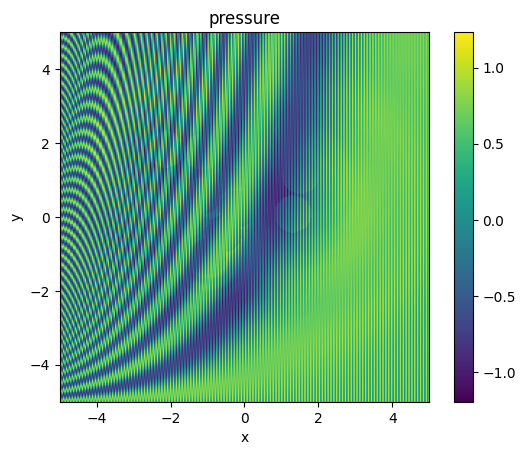

In [19]:

# acoustic_deeponet.py
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
from source import create_source
from vis import Avis
from dde_param import AcousticDeepONet

f_pos, pe = AcousticDeepONet.positional(f, freq = 500)

plt.imshow((f_pos), extent=[-L/2, L/2, -L/2, L/2], origin='lower', cmap=cm.viridis)
plt.xlabel("x")
plt.ylabel("y")
plt.title("pressure")
plt.colorbar()
plt.show()


位置索引：
$$ [\text{position} = \begin{bmatrix} 0 \ 1 \ \vdots \ \text{maxlen} - 1 \end{bmatrix} ]
$$
频率指数：

$$[ \text{divterm} = \exp\left(\frac{-\log(10000.0)}{d_{\text{model}}} \times \begin{bmatrix} 0 \ 1 \ \vdots \ d_{\text{model}}/2 - 1 \end{bmatrix}\right) ]
$$

这些组成部分最终用于计算位置编码：
$$ [ \text{PE}{(\text{pos}, 2i)} = \sin(\text{pos} \times \text{divterm}[i]) ] [ \text{PE}{(\text{pos}, 2i+1)} = \cos(\text{pos} \times \text{divterm}[i]) ]$$

其中 (\text{pos}) 是位置，(i) 代表维度的索引。这个位置编码方案为输入序列提供了一种位置信息，以便模型注意机制能够充分利用输入数据的顺序信息。

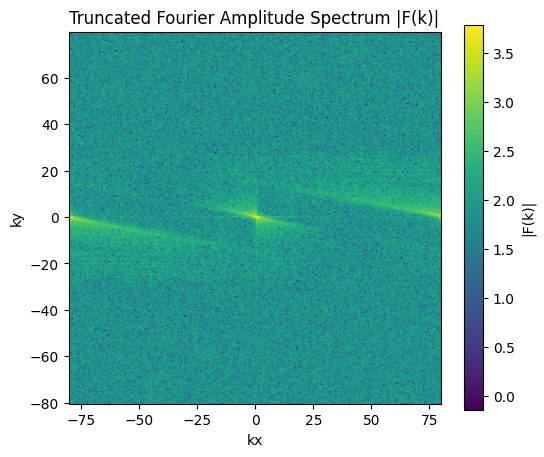

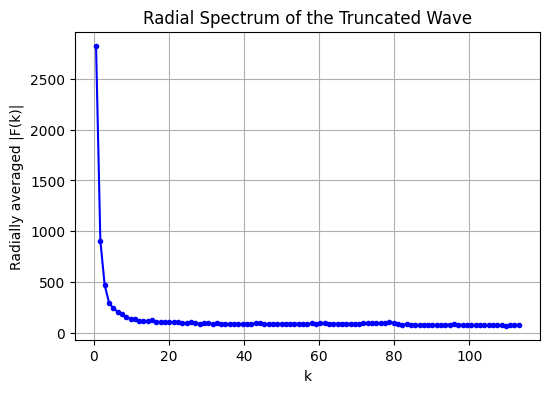

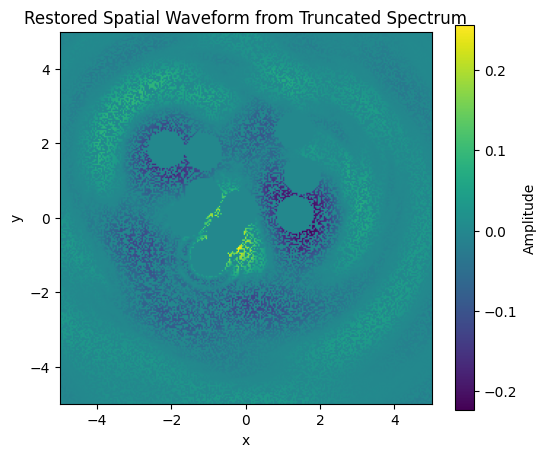

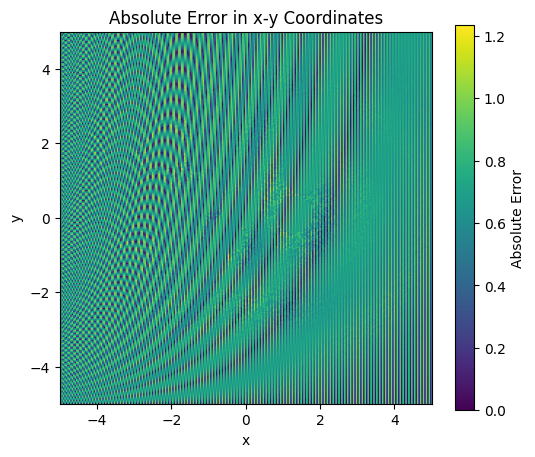

Relative error: 4.7917e-02


'\nThe code provided performs the following steps:\n1. **Fourier Transform**: Computes the 2D Fourier transform of the input waveform `f`.\n2. **Radial Averaging**: Averages the Fourier coefficients in radial bins to obtain a radially averaged spectrum.\n3. **Plotting**: Plots the radially averaged spectrum.\n4. **Inverse Fourier Transform**: Computes the inverse Fourier transform to restore the original spatial waveform.\n5. **Error Calculation**: Calculates the relative error between the original and restored waveforms.\nThe relative error is a measure of how well the restored waveform matches the original waveform. A smaller relative error indicates a better restoration.\n'

In [20]:
# Create a mask for f
mask = np.zeros_like(f_pos)

# Use non-periodic random sampling instead of periodic
np.random.seed(0)
random_indices = np.random.rand(N, N) < 0.5  # 4% of the data points are sampled
mask[random_indices] = 1
# Apply the mask to f
f_masked = f_pos * mask
pe_m = pe * mask

# Fourier transform on the masked f
F = np.fft.fftshift(np.fft.fft2(f_masked))

# Frequency domain setup
dk = 2 * np.pi / L
kx = np.fft.fftshift(np.fft.fftfreq(N, d=(L/N))) * 2 * np.pi
ky = np.fft.fftshift(np.fft.fftfreq(N, d=(L/N))) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)

# Truncate F: zero out components where kx or ky is greater than 20
F_truncated = F.copy()
truncation_mask = (np.abs(KX) > 100) | (np.abs(KY) > 100)
F_truncated[truncation_mask] = 0

# Plot the truncated Fourier amplitude spectrum
plt.figure(figsize=(6, 5))
plt.imshow(np.log10(np.abs(F_truncated)), extent=[kx[0], kx[-1], ky[0], ky[-1]], origin='lower', cmap=cm.viridis)
plt.title("Truncated Fourier Amplitude Spectrum |F(k)|")
plt.xlabel("kx")
plt.ylabel("ky")
plt.colorbar(label='|F(k)|')
plt.show()

# Radial average of the truncated Fourier spectrum
k_flat = K.flatten()
F_flat = np.abs(F).flatten()

num_bins = 100
k_bins = np.linspace(0, np.max(k_flat), num_bins)
k_bin_centers = 0.5 * (k_bins[1:] + k_bins[:-1])
F_radial = np.zeros(num_bins - 1)

for i in range(num_bins - 1):
    mask = (k_flat >= k_bins[i]) & (k_flat < k_bins[i+1])
    if np.sum(mask) > 0:
        F_radial[i] = np.mean(F_flat[mask])

plt.figure(figsize=(6, 4))
plt.plot(k_bin_centers, F_radial, 'b.-')
plt.xlabel("k")
plt.ylabel("Radially averaged |F(k)|")
plt.title("Radial Spectrum of the Truncated Wave")
plt.grid(True)
plt.show()

# Restore the original spatial waveform by the inverse Fourier transform
f_restored = np.fft.ifft2(np.fft.ifftshift(F_truncated)) - pe_m

plt.figure(figsize=(6, 5))
plt.imshow(np.real(f_restored), extent=[-L/2, L/2, -L/2, L/2], origin='lower', cmap=cm.viridis)
plt.title("Restored Spatial Waveform from Truncated Spectrum")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label='Amplitude')
plt.show()

# Calculate the error between the original and restored waveforms
# Calculate the absolute error between the original and restored waveforms
absolute_error = np.abs(f_pos - f_restored)

# Plot the error in the x-y coordinate space
plt.figure(figsize=(6, 5))
plt.imshow(absolute_error, extent=[-L/2, L/2, -L/2, L/2], origin='lower', cmap=cm.viridis)
plt.title("Absolute Error in x-y Coordinates")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label='Absolute Error')
plt.show()
# Calculate and print the relative error
relative_error = np.linalg.norm(f_pos - f_restored - pe) / np.linalg.norm(f_pos)
print(f"Relative error: {relative_error:.4e}")

'''
The code provided performs the following steps:
1. **Fourier Transform**: Computes the 2D Fourier transform of the input waveform `f`.
2. **Radial Averaging**: Averages the Fourier coefficients in radial bins to obtain a radially averaged spectrum.
3. **Plotting**: Plots the radially averaged spectrum.
4. **Inverse Fourier Transform**: Computes the inverse Fourier transform to restore the original spatial waveform.
5. **Error Calculation**: Calculates the relative error between the original and restored waveforms.
The relative error is a measure of how well the restored waveform matches the original waveform. A smaller relative error indicates a better restoration.
'''

一、空间傅里叶变换的数学推导
1. 定义与公式
空间傅里叶变换（Spatial Fourier Transform）将函数 $( f(\mathbf{x}) ) $ 从空间域转换到波数域（k-space），
$$
其定义为： [ \mathcal{F}{f}(\mathbf{k}) = \hat{f}(\mathbf{k}) = \int_{-\infty}^{\infty} f(\mathbf{x}) e^{-i \mathbf{k} \cdot \mathbf{x}} , d\mathbf{x} ] $$
$$
逆变换为： [ f(\mathbf{x}) = \frac{1}{(2\pi)^n} \int_{-\infty}^{\infty} \hat{f}(\mathbf{k}) e^{i \mathbf{k} \cdot \mathbf{x}} , d\mathbf{k} ] 其中 ( \mathbf{x} ) 是空间坐标，( \mathbf{k} ) 是波数向量，( n ) 是空间维度。
$$
2. 声学中的波动方程
在声学中，声波的传播可由波动方程描述：
$$
[ \nabla^2 p(\mathbf{x}, t) - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = -s(\mathbf{x}, t) ] 其中 ( p ) 是声压，( c ) 是声速，( s ) 是声源项
$$

$$
通过傅里叶变换将时间域转换到频率域 ( \omega )，波动方程变为Helmholtz方程： [ \nabla^2 \hat{p}(\mathbf{x}, \omega) + k^2 \hat{p}(\mathbf{x}, \omega) = -\hat{s}(\mathbf{x}, \omega) ] 其中 ( k = \omega/c ) 是波数。
$$
3. 空间傅里叶变换求解Helmholtz方程
$$对Helmholtz方程进行空间傅里叶变换： [ (-|\mathbf{k}|^2 + k^2) \hat{p}(\mathbf{k}, \omega) = -\hat{s}(\mathbf{k}, \omega) ] 解得： [ \hat{p}(\mathbf{k}, \omega) = \frac{\hat{s}(\mathbf{k}, \omega)}{|\mathbf{k}|^2 - k^2} ] $$
$$
逆变换得到空间域的解： [ p(\mathbf{x}, \omega) = \frac{1}{(2\pi)^3} \int \frac{\hat{s}(\mathbf{k}, \omega)}{|\mathbf{k}|^2 - k^2} e^{i \mathbf{k} \cdot \mathbf{x}} , d\mathbf{k} ]
$$
二、Green函数的傅里叶变换
1. Green函数的定义
$$Green函数 ( G(\mathbf{x}, \mathbf{x}') ) 是方程： [ \nabla^2 G + k^2 G = -\delta(\mathbf{x} - \mathbf{x}') ] 的解，代表点源在 ( \mathbf{x}' ) 处产生的场。
$$
2. Green函数的空间傅里叶变换
$$对Green函数方程进行傅里叶变换： [ (-|\mathbf{k}|^2 + k^2) \hat{G}(\mathbf{k}) = -1 \implies \hat{G}(\mathbf{k}) = \frac{1}{|\mathbf{k}|^2 - k^2} ]$$ 

$$逆变换得到： [ G(\mathbf{x}, \mathbf{x}') = \frac{1}{(2\pi)^3} \int \frac{e^{i \mathbf{k} \cdot (\mathbf{x} - \mathbf{x}')}}{|\mathbf{k}|^2 - k^2} , d\mathbf{k} ] 在三维空间中，解析解为： [ G(\mathbf{x}, \mathbf{x}') = \frac{e^{ik|\mathbf{x} - \mathbf{x}'|}}{4\pi |\mathbf{x} - \mathbf{x}'|} ]$$

三、声学中的应用示例
1. 点源辐射声场
$$假设声源为点源 ( s(\mathbf{x}) = \delta(\mathbf{x}) )，其傅里叶变换为 ( \hat{s}(\mathbf{k}) = 1 )。$$
$$
代入解公式： [ p(\mathbf{x}) = \frac{1}{(2\pi)^3} \int \frac{e^{i \mathbf{k} \cdot \mathbf{x}}}{|\mathbf{k}|^2 - k^2} , d\mathbf{k} ] 这直接对应Green函数 ( G(\mathbf{x}) )，即声压场为： [ p(\mathbf{x}) = \frac{e^{ik|\mathbf{x}|}}{4\pi |\mathbf{x}|} ]$$


2. 近场声全息（Near-field Acoustic Holography, NAH）
原理：通过测量某一平面（全息面）的声压 ( p(x,y,z_0) )，利用傅里叶变换将其转换到波数域 ( \hat{p}(k_x,k_y,z_0) )，再通过传播算子外推到其他平面。

公式推导：
$$
对全息面声压进行2D傅里叶变换： [ \hat{p}(k_x,k_y,z_0) = \iint p(x,y,z_0) e^{-i(k_x x + k_y y)} dx dy ]$$

$$应用传播算子外推到目标平面 ( z )： [ \hat{p}(k_x,k_y,z) = \hat{p}(k_x,k_y,z_0) \cdot e^{ik_z (z - z_0)} ] $$
$$
其中 ( k_z = \sqrt{k^2 - k_x^2 - k_y^2} )（当 ( k^2 > k_x^2 + k_y^2 ) 时为传播波，否则为衰减波）。
$$
$$
逆傅里叶变换得到空间域声压： [ p(x,y,z) = \frac{1}{(2\pi)^2} \iint \hat{p}(k_x,k_y,z) e^{i(k_x x + k_y y)} dk_x dk_y ]
$$


五、与Green函数的结合
在更复杂的场景中（如存在反射边界），可将Green函数与全息方法结合：
$$
 [ p(\mathbf{x}) = \int G(\mathbf{x}|\mathbf{x'}) s(\mathbf{x'}) d\mathbf{x'} ] 
 $$
 通过全息数据反演声源分布 ( s(\mathbf{x'}) )，需要求解逆问题（如Tikhonov正则化）。



### 关于训练问题，如果对于球形数据训练，仅提供spherical source 的不同参数组合情况下，球近场的声场数据将会是最common的数据，从而会导致，网络over adaptive这一情况。



正弦和余弦函数：

使用不同频率的正弦和余弦函数来编码位置。
通常对维度进行分段，每个维度使用不同的正弦或余弦公式： 

$$[ PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right) ] \\
[ PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right) ]$$

这里 (pos) 是位置，(i) 是编码维度，(d) 是总的编码维度。
这种方式提供了连续和可微的位置信息，并且能让模型在不同尺度下都获取位置。
可学习的位置编码：

将位置编码作为可训练参数，与其他模型参数一起学习。
能够灵活适应特定任务的需求。